In [1]:
from __future__ import annotations

from itertools import cycle
from torch.optim import Optimizer
from torch.utils.data import (DataLoader, Dataset)
from torchvision.datasets import MNIST, EMNIST
from tqdm import tqdm

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np



# class EMNISTDataset(Dataset):
#     def __init__(self, train: bool, path: str, device: torch.device) -> None:
#         super().__init__()
#         self.path = path
#         self.prefix = 'train' if train else 'test'
#         self.path_xs = os.path.join(self.path, f'EMNIST_{self.prefix}_xs.pt')
#         self.path_ys = os.path.join(self.path, f'EMNIST_{self.prefix}_ys.pt')
#         self.transform = T.Compose([T.ToTensor(), T.Normalize((0.1307, ), (0.3081, ))])

#         if not os.path.exists(self.path_xs) or not os.path.exists(self.path_ys):
#             set = EMNIST(path, train=train, download=True, transform=self.transform, split="byclass")
#             loader = DataLoader(set, batch_size=batch_size, shuffle=train)
#             n = len(set)

#             xs = torch.empty((n, *set[0][0].shape), dtype=torch.float32)
#             ys = torch.empty((n, ), dtype=torch.long)
#             desc = f'Preparing {self.prefix.capitalize()} Set'
#             for i, (x, y) in enumerate(tqdm(loader, desc=desc)):
#                 xs[i * batch_size:min((i + 1) * batch_size, n)] = x
#                 ys[i * batch_size:min((i + 1) * batch_size, n)] = y

#             torch.save(xs, self.path_xs)
#             torch.save(ys, self.path_ys)
        
#         self.device = device
#         self.xs = torch.load(self.path_xs, map_location=self.device)
#         self.ys = torch.load(self.path_ys, map_location=self.device)

#     def __len__(self) -> int:
#         return len(self.xs)

#     def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
#         return self.xs[idx], self.ys[idx]

class MYDataset(Dataset):
    def __init__(self, train: bool, path: str, device: torch.device) -> None:
        super().__init__()
        self.path = path
        self.transform = T.Compose([T.ToTensor(), T.Normalize((0.1307, ), (0.3081, ))])
        set = EMNIST(path, train=train, download=True, transform=self.transform,split="byclass")

        self.classes = set.classes

        self.device = device

        self.xs = set.data.unsqueeze(dim=1).float().to(device)
        self.ys = set.targets.to(device)

        # print(self.xs.shape)
        # print(self.xs[0])
        # print(self.ys.shape)
        # print(self.ys[0])                

    def __len__(self) -> int:
        return len(self.xs)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.xs[idx], self.ys[idx]

class FeaturesDector(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 24, 3, 1,bias=False),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            # nn.Dropout2d(0.1),
            nn.Conv2d(24, out_channels, 3, 1,bias=False),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class MLP(nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, out_features,bias=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)


class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv = FeaturesDector(1, 32)
        self.flat = nn.Flatten(1)
        self.fc = MLP(800, 62)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.flat(x)
        x = self.fc(x)
        return x
    
    def fit(self, loader: DataLoader, optimizer: Optimizer, scheduler, epochs: int) -> None:
        self.train()
        batches = iter(cycle(loader))
        for _ in tqdm(range(epochs * len(loader)), desc='Training'):
            x, l = next(batches)
            optimizer.zero_grad(set_to_none=True)
            logits = self(x)
            loss = F.nll_loss(torch.log_softmax(logits, dim=1), l)
            loss.backward()
            optimizer.step()
            scheduler.step()

    @torch.inference_mode()
    def test(self, loader: DataLoader) -> None:
        self.eval()
        loss, acc = 0, 0.0
        for x, l in tqdm(loader, total=len(loader), desc='Testing'):
            logits = self(x)
            preds = torch.argmax(logits, dim=1, keepdim=True)
            loss += F.nll_loss(torch.log_softmax(logits, dim=1), l, reduction='sum').item()
            acc += (preds == l.view_as(preds)).sum().item()
        print()
        print(f'Loss: {loss / len(loader.dataset):.2e}')
        print(f'Accuracy: {acc / len(loader.dataset) * 100:.2f}%')
        print()


In [3]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

import torch.onnx as tonnx

device = torch.device('cuda')
epochs = 4
batch_size = 512*2
lr = 1e-2


# from torchinfo import summary
# summary(CNN(), input_size=(batch_size, 1, 28, 28), col_names=["input_size","output_size","num_params","kernel_size"])

path = os.path.expanduser('~') + "/Datasets"
# path = "/Datasets"
file_dir = os.path.abspath("")+"/"

# train_set = MNIST(root=path, download=True, train=True, transform=T.ToTensor())
train_set=MYDataset(True, path, device)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
print(f"Shape of train_set: {train_set.xs.shape}")

# test_set = MNIST(root=path, train=True, transform=T.ToTensor())
test_set=MYDataset(False, path, device)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(train_set.classes)

model = CNN().to(device)

Shape of train_set: torch.Size([697932, 1, 28, 28])
Shape of X [N, C, H, W]: torch.Size([1024, 1, 28, 28])
Shape of y: torch.Size([1024]) torch.int64
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [223]:
optimizer = AdamW(model.parameters(), lr=lr)#, betas=(0.7, 0.9)) 
scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=int(((len(train_set) - 1) // batch_size + 1) * epochs))
model.fit(train_loader, optimizer, scheduler, epochs)
model.test(test_loader)
model.eval()
torch.save(model.state_dict(), file_dir+'EMNIST_cnn.pt')

Testing: 100%|██████████| 114/114 [00:00<00:00, 171.79it/s]


Loss: 3.32e-01
Accuracy: 87.52%



torch.Size([1, 28, 28])


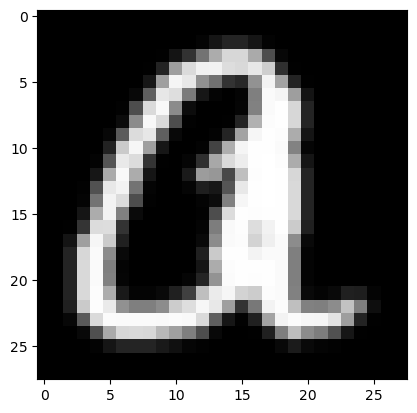

tensor(36, device='cuda:0') tensor(36, device='cuda:0') a a


In [3]:
with torch.inference_mode():
    model.load_state_dict(torch.load(file_dir+'EMNIST_cnn.pt'))
    model.eval()
    x,y = test_set[1]
    y_ = model(x.unsqueeze(dim=0)).argmax()
    print(x.shape)
    plt.imshow(x[0].transpose(0,1).cpu(), cmap='gray')
    # plt.show()
    plt.show(block=False)
    # print(y_)
    print(y,y_,test_set.classes[y],test_set.classes[y_])

tensor([ 41932,   5536,  26552,  55661,  55982,  44868, 112808,  89276, 110359,
         75076,  93828,  84366,  69239,  92056,  94428,   8561,  46839,  30078,
         59718,  48690,  90298,  81460,  79724,  49531])
tensor([ 5, 54, 12, 40, 33,  5, 47,  3, 10, 29, 24,  1,  2,  2,  2, 31,  2, 30,
        29, 15, 45,  6,  4, 55], device='cuda:0')
tensor([ 5, 28, 12, 40, 33,  5,  1,  3, 10, 29, 24,  1,  2,  2, 21, 31,  2, 30,
        29, 15, 19,  6,  4, 55], device='cuda:0')


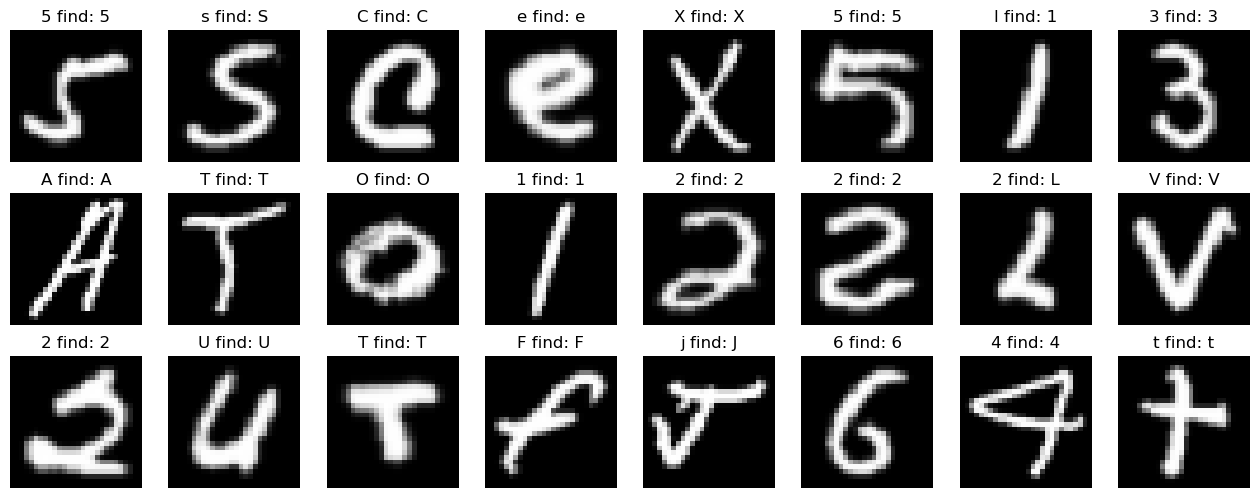

In [29]:
figure = plt.figure(figsize=(16, 6))
cols, rows = 8, 3
sample_idxs = torch.randint(len(test_set), size=(cols*rows,))
print(sample_idxs)
imgs, labels = test_set[sample_idxs]
c_label = model(imgs).argmax(1)
print(labels)
print(c_label)
for i in range(0, cols * rows):
    # sample_idx = torch.randint(len(test_set), size=(1,)).item()
    # img, label = test_set[sample_idx]
    figure.add_subplot(rows, cols, i+1)
    plt.title(test_set.classes[labels[i]]+ " find: "+test_set.classes[c_label[i]])
    plt.axis("off")
    plt.imshow(imgs[i].squeeze().T.cpu(), cmap="gray")

In [231]:
tonnx.export(
    model,
    torch.empty((1, 1, 28, 28), dtype=torch.float32).to(device),
    file_dir+'EMNIST.onnx',
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
)

import onnx

onnx_model = onnx.load(file_dir+'EMNIST.onnx')
onnx.checker.check_model(onnx_model)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/usr/lib/python3.11/site-packages/torch/onnx/utils.py:506: FutureWarning: Caffe2 ONNX exporter is deprecated in version 2.0 and will be removed in 2.2. Please use PyTorch 2.1 or older for this capability.
  _export(


In [280]:
x,_ = test_set[1:78]
torch_out = model(x)

import onnxruntime

ort_session = onnxruntime.InferenceSession("EMNIST.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")



Exported model has been tested with ONNXRuntime, and the result looks good!


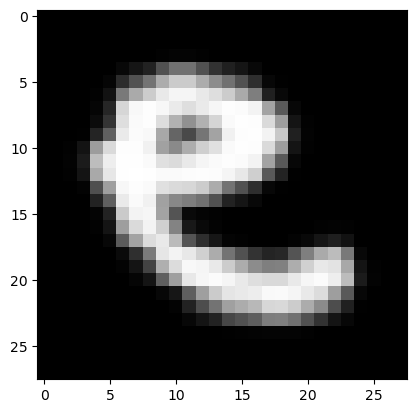

tensor(40, device='cuda:0') 40 e e


In [277]:
with torch.inference_mode():
    x,y = test_set[546]
    plt.imshow(x[0].transpose(0,1).cpu(), cmap='gray')
    img_y = x.unsqueeze(0)
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
    ort_outs = ort_session.run(None, ort_inputs)
    out_y = ort_outs[0][0]
    y_=np.argmax(out_y)
    # plt.show()
    plt.show(block=False)
    # print(y_)
    print(y,y_,test_set.classes[y],test_set.classes[y_])